In [9]:


from optyx.channel import *

(3.749399456654641e-33+0j)


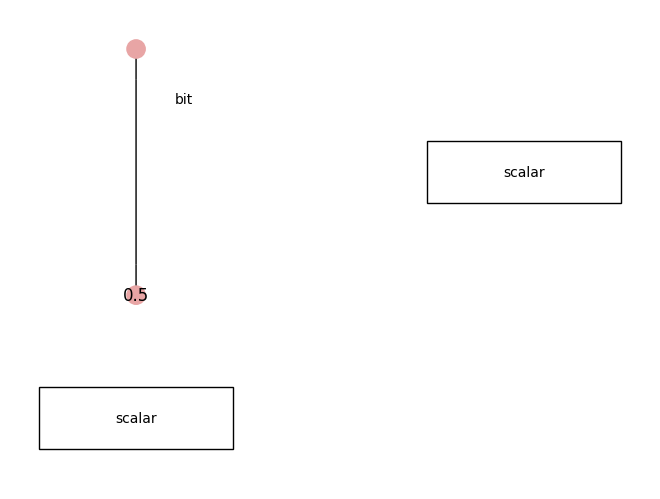

In [76]:
ket_0 = zx.X(0, 1) @ optyx.Scalar(1 / np.sqrt(2))
Ket_0 = Channel('|0>', ket_0)

ket_1 = zx.X(0, 1, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Ket_1 = Channel('|1>', ket_1)

ket_plus = zx.Z(0, 1) @ optyx.Scalar(1 / np.sqrt(2))
Ket_plus = Channel('|+>', ket_plus)

ket_minus = zx.Z(0, 1, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Ket_minus = Channel('|->', ket_minus)

bra_0 = zx.X(1, 0) @ optyx.Scalar(1 / np.sqrt(2))
Bra_0 = Channel('<0|', bra_0)

bra_1 = zx.X(1, 0, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Bra_1 = Channel('<1|', bra_1)

bra_plus = zx.Z(1, 0) @ optyx.Scalar(1 / np.sqrt(2))
Bra_plus = Channel('<+|', bra_plus)

bra_minus = zx.Z(1, 0, phase=0.5) @ optyx.Scalar(1 / np.sqrt(2))
Bra_minus = Channel('<-|', bra_minus)

Bit_0 = Channel('<0|', bra_0, dom=bit)
Bit_1 = Channel('<1|', bra_1, dom=bit)


def diag_pow(diag, n):
    if n == 1:
        return diag
    return diag @ diag_pow(diag, n - 1)


print((Ket_0 >> Bra_1).double().to_tensor().eval().array)
(ket_0 >> bra_1).draw()

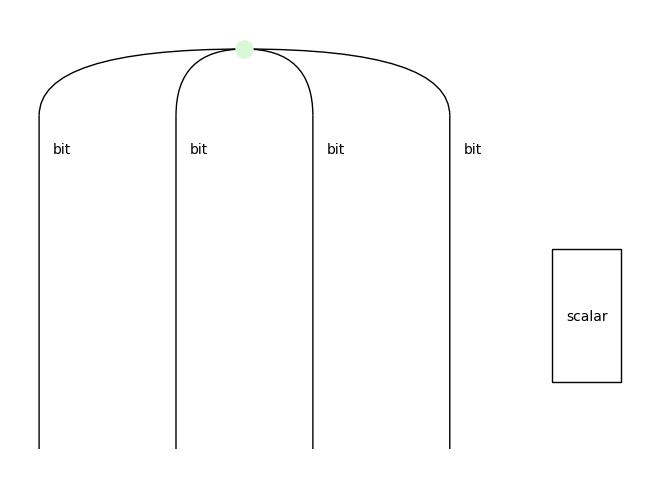

In [164]:
logical_ket_00 = zx.Z(0, 4) @ optyx.Scalar(1 / np.sqrt(2))
Logical_ket_00 = Channel('|00>', logical_ket_00)

logical_bra_00 = zx.Z(4, 0) @ optyx.Scalar(1 / np.sqrt(2))
Logical_bra_00 = Channel('<00|', logical_bra_00)

logical_ket_00.draw()

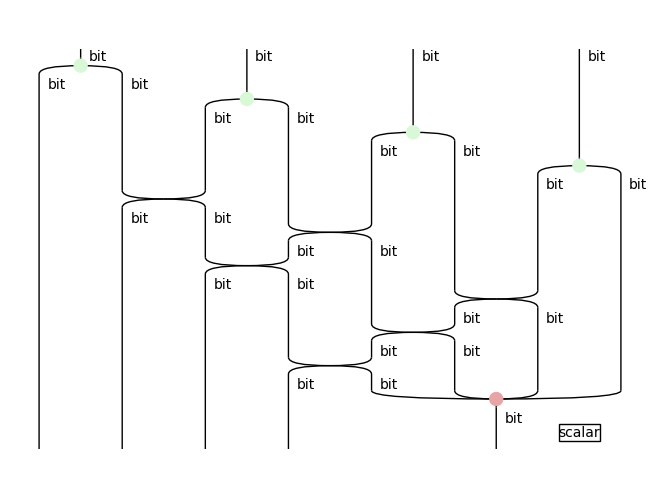

In [13]:
x_detector = (
        (zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(1, 2))
        >> optyx.Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], optyx.bit ** 8)
        >> optyx.Id(optyx.bit ** 4) @ zx.X(4, 1)
        @ zx.Scalar(np.sqrt(2) ** 3)
)
X_detector = Channel('X Error Detector', x_detector, dom=qubit ** 4, cod=qubit ** 4 @ bit)

x_detector.draw()

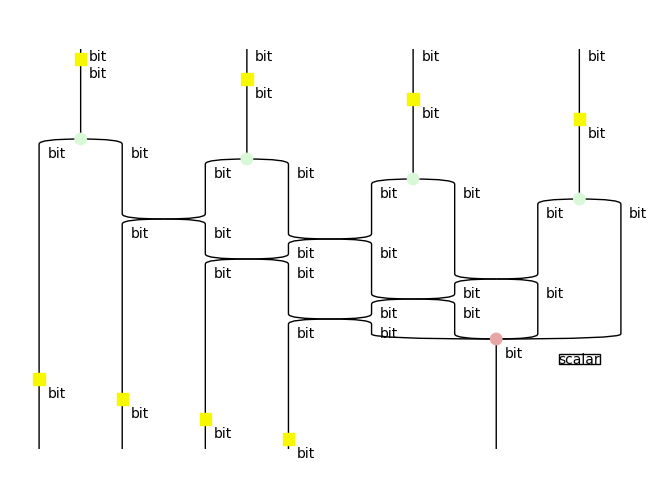

In [14]:
z_detector = diag_pow(zx.H, 4) >> x_detector >> diag_pow(zx.H, 4) @ zx.Id(1)
Z_detector = Channel('Z Error Detector', z_detector, dom=qubit ** 4, cod=qubit ** 4 @ bit)

z_detector.draw()

### Fidelity on a 4 qubit state without error-detection

(0.8280499999999968+0j)


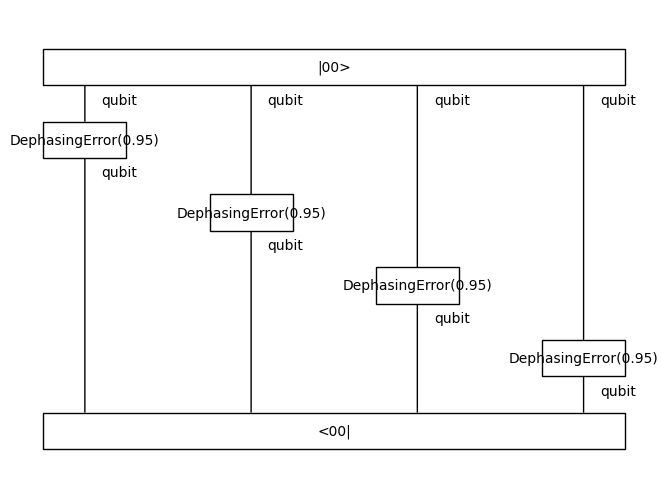

In [49]:
Imperfect_circuit = Logical_ket_00 >> diag_pow(DephasingError(0.95), 4) >> Logical_bra_00

print(Imperfect_circuit.double().to_tensor().eval().array)
Imperfect_circuit.draw()

### Calculating the fidelity of |00> in the post-selected [4,2,2] code, assuming perfect measurements

To calculate fidelity, we use
$$
P(<00| | S = 0) = \frac{P(<00| \land S = 0)}{P(S = 0)}
$$
where $S$ is the syndrome measurement.

In [171]:
p_error = 0.99

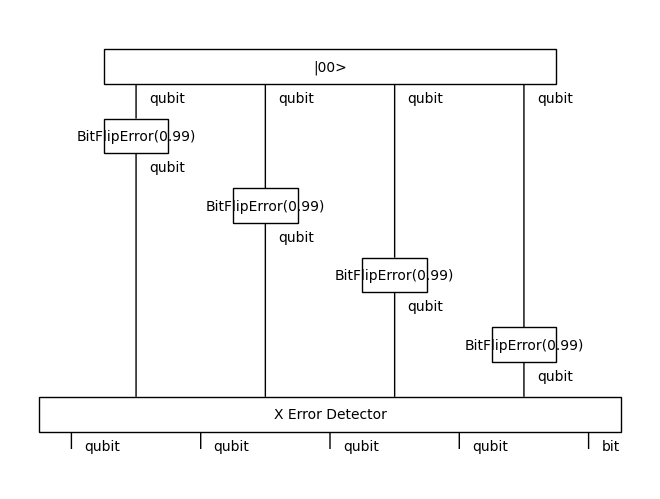

In [172]:
Imperfect_circuit = Logical_ket_00 >> diag_pow(BitFlipError(p_error), 4) >> X_detector
Imperfect_circuit.draw()

In [185]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bra_00 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print(np.sqrt(fidelity) - p_error)

(0.00969404925409223+0j)


#### For the physical implementation, the fidelity is given as follows:

In [170]:
Physical_Ket_00 = Ket_0 @ Ket_0 >> diag_pow(BitFlipError(p_error), 2) >> Bra_0 @ Bra_0
print(Physical_Ket_00.double().to_tensor().eval().array)
print(0.9 ** 2)

(0.809999999999998+0j)
0.81


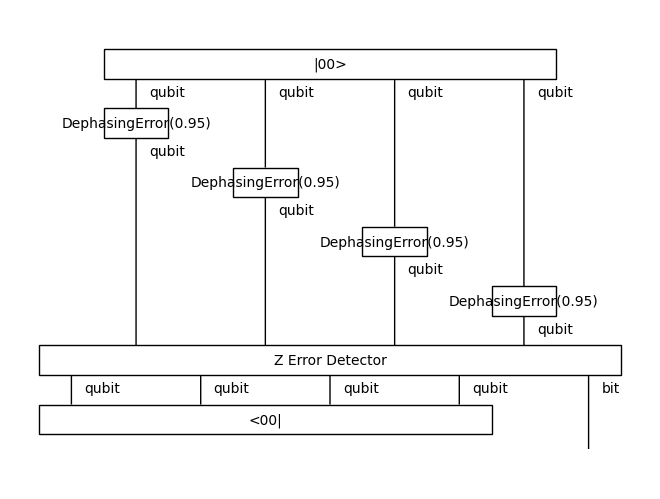

In [62]:
Imperfect_circuit.draw()

# Fidelity of the Bell state with perfect measurements

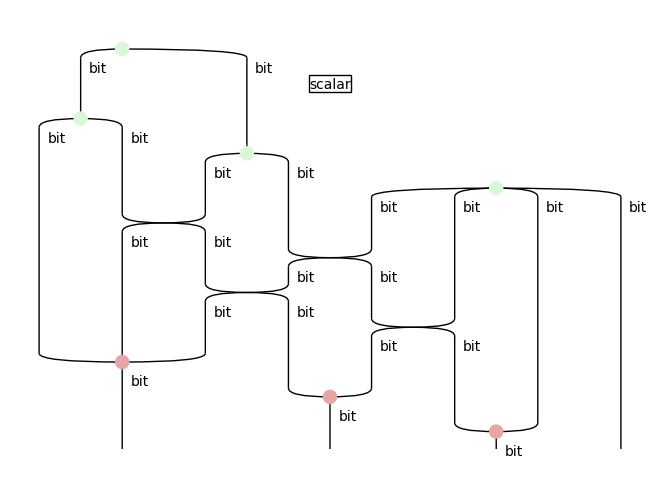

In [239]:
encoder = (
        zx.Z(1, 2) @ zx.Z(1, 2) @ zx.Z(0, 4)
        >> optyx.Diagram.permutation([0,2,4,1,5,3,6,7], optyx.bit ** 8)
        >> zx.X(3,1) @ zx.X(2,1) @ zx.X(2,1) @ zx.Id(1)
)

logical_bell = zx.Z(0,2) @ zx.Scalar(2) >> encoder
logical_bell_measurement = logical_bell.dagger()

Logical_bell = Channel('|00> + |11>', logical_bell)
Logical_bell_measurement = Channel('<00| + <11|', logical_bell_measurement)

logical_bell.draw()

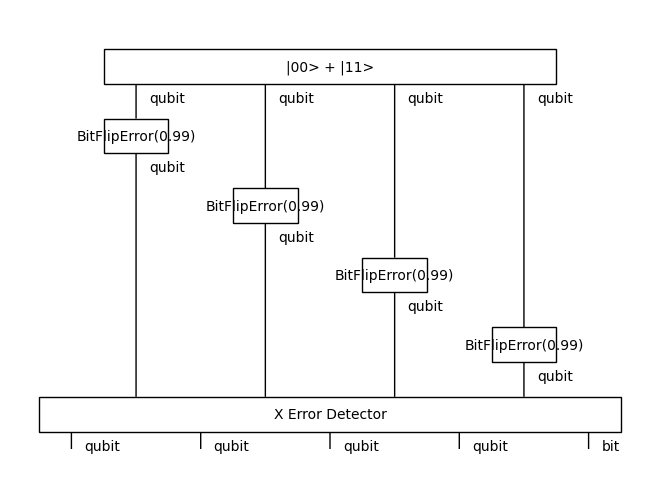

In [241]:
Imperfect_circuit = Logical_bell >> diag_pow(BitFlipError(p_error), 4) >> X_detector

Imperfect_circuit.draw()

In [242]:
P_s_eq_0 = Imperfect_circuit >> Discard(qubit ** 4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
fidelity

(0.9995921280760274+0j)